Loaded saved model from: ..\outputs\random_forest_model.pkl

🔎 Validation Accuracy: 1.0000

📋 Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       110
           1      1.000     1.000     1.000        69

    accuracy                          1.000       179
   macro avg      1.000     1.000     1.000       179
weighted avg      1.000     1.000     1.000       179



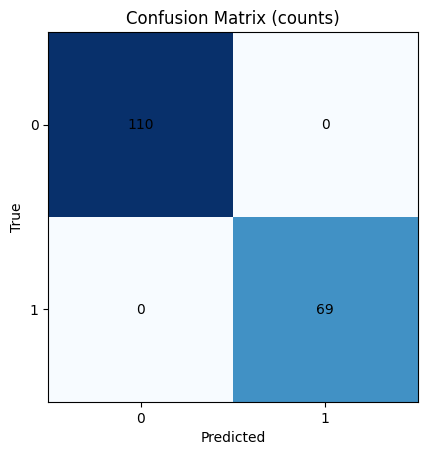

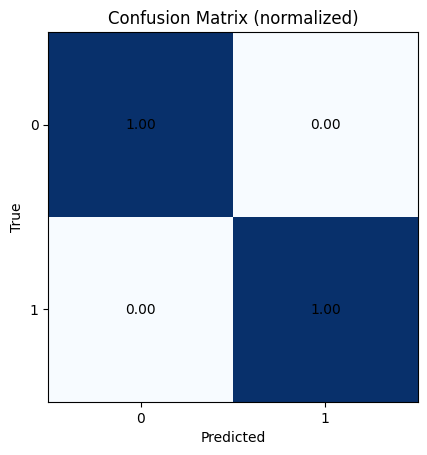


📊 5-fold CV Accuracy: mean=0.8305  std=0.0184
Fold scores: [0.8436 0.8202 0.809  0.8202 0.8596]

🔬 Model-based Importance / Coefficients:


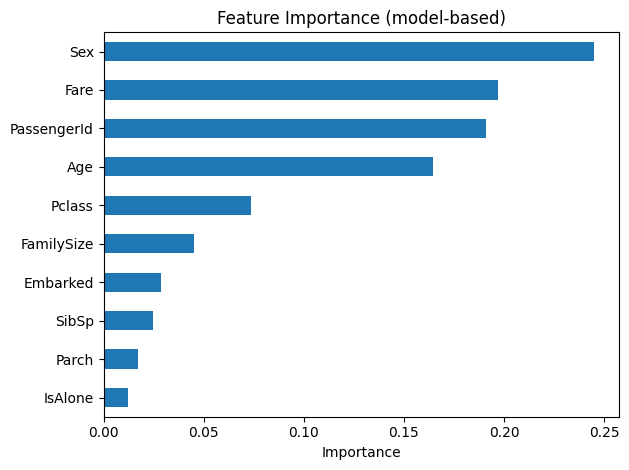


🧪 Permutation Importance (validation set):


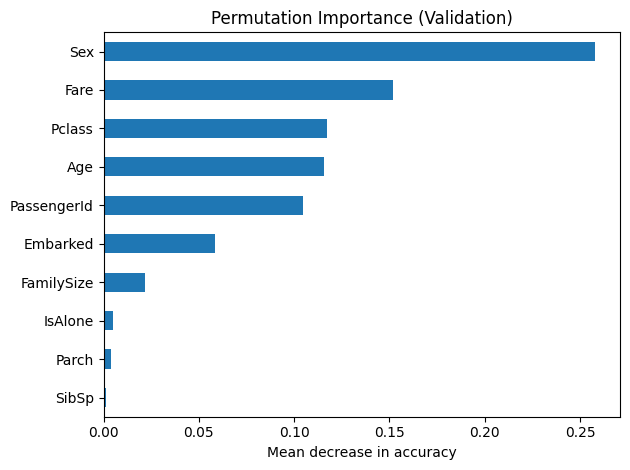


Top permutation importance features:
Sex            0.258101
Fare           0.151955
Pclass         0.117318
Age            0.115642
PassengerId    0.104469
Embarked       0.058659
FamilySize     0.021788
IsAlone        0.005028
Parch          0.003911
SibSp          0.001117
dtype: float64

✅ Evaluation complete.


In [1]:
# STEP 4 — Model Evaluation & Interpretation
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

# --- 1) Load processed data fresh ---
PROC_DIR = Path("../data/processed")
OUT_DIR  = Path("../outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(PROC_DIR / "train_processed.csv")

# --- 2) Separate features/target and split (same seed & stratify as Step 3) ---
X = df.drop(columns=["Survived"], errors="ignore")
y = df["Survived"].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3) Load the saved best model if available; else train a robust baseline ---
model_path = OUT_DIR / "random_forest_model.pkl"
model = None
if model_path.exists():
    model = joblib.load(model_path)
    print(f"Loaded saved model from: {model_path}")
else:
    print("No saved model found; training a new RandomForest baseline.")
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X, y)
    joblib.dump(model, model_path)
    print(f"New model trained and saved to: {model_path}")

# --- 4) Metrics on validation set ---
y_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, y_pred)
print(f"\n🔎 Validation Accuracy: {val_acc:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_val, y_pred, digits=3))

# --- 5) Confusion matrices (counts + normalized) ---
cm = confusion_matrix(y_val, y_pred, labels=[0,1])
cm_norm = confusion_matrix(y_val, y_pred, labels=[0,1], normalize="true")

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix (counts)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(cm_norm, cmap="Blues")
ax.set_title("Confusion Matrix (normalized)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.show()

# --- 6) Stratified K-fold cross-validation (robust estimate) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=None)
print(f"\n📊 5-fold CV Accuracy: mean={cv_scores.mean():.4f}  std={cv_scores.std():.4f}")
print("Fold scores:", np.round(cv_scores, 4))

# --- 7) Feature importance (tree-based) OR coefficients (logistic) ---
def show_feature_importance(model, X, top_n=12):
    if hasattr(model, "feature_importances_"):
        importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
        top = importances.head(top_n)[::-1]  # reverse for horizontal plot
        top.plot(kind="barh")
        plt.title("Feature Importance (model-based)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
        return importances
    elif isinstance(model, LogisticRegression):
        coefs = pd.Series(model.coef_[0], index=X.columns).sort_values()
        coefs.plot(kind="barh")
        plt.title("Logistic Coefficients")
        plt.xlabel("Coefficient")
        plt.tight_layout()
        plt.show()
        return coefs
    else:
        print("Model does not expose feature_importances_ or logistic coefficients.")
        return None

print("\n🔬 Model-based Importance / Coefficients:")
_ = show_feature_importance(model, X)

# --- 8) Model-agnostic permutation importance (on validation set) ---
print("\n🧪 Permutation Importance (validation set):")
perm = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42)
perm_importance = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

top_perm = perm_importance.head(12)[::-1]
top_perm.plot(kind="barh")
plt.title("Permutation Importance (Validation)")
plt.xlabel("Mean decrease in accuracy")
plt.tight_layout()
plt.show()

print("\nTop permutation importance features:")
print(perm_importance.head(10))

print("\n✅ Evaluation complete.")


## Interpreting Results: Generalization & Feature Importance

### 1) Cross-Validation (CV) — Generalization
- **What it is:** Train/validate across multiple folds (e.g., 5) and report the **mean ± std** accuracy.
- **Why it matters:** Reduces luck from a single split and estimates out-of-sample performance.
- **How to read it:**
  - Higher **mean** = better expected performance on new data.
  - Lower **std** = more **stable** model (less sensitive to which rows it sees).
  - Example: `0.842 ± 0.018` → strong and stable. `0.84 ± 0.07` → unstable.

### 2) Model-Based Importance — What the model relies on
- **Trees (RandomForest):** `feature_importances_` reflects how much each feature reduces impurity across splits.
- **Linear (LogReg):** Larger absolute coefficients = stronger effect on the predicted log-odds of survival.
- **Use it for:** Understanding the model’s **internal logic** and which features it *thinks* are predictive.

### 3) Permutation Importance — What truly drives predictions
- **How it works:** Randomly shuffle one feature in the **validation** set and measure the drop in accuracy.
- **Interpretation:** Bigger drop ⇒ model **depends** on that feature; small drop ⇒ feature may be redundant or unhelpful.
- **Use it for:** Validating importance **outside** the model’s internals (model-agnostic sanity check).

### 4) Consistency Check (Model-based vs Permutation)
- **Agree (both high):** Strong, reliable signal (e.g., typically `Sex`, `Pclass` on Titanic).
- **Disagree:** Investigate! Possible redundancy (e.g., `Fare` vs `Pclass`) or mild overfitting/noise (e.g., `Embarked`).

### 5) Typical Titanic Signals (rule-of-thumb)
- **Strong:** `Sex`, `Pclass`
- **Moderate:** `Age`, `Fare`, `FamilySize` / `IsAlone`
- **Minor:** `Embarked`

> **Actionable tips:**  
> • Prefer the **CV mean ± std** to choose models.  
> • Use **permutation importance** to confirm what truly matters.  
> • If two features carry the same signal (e.g., `Fare` and `Pclass`), consider simplifying to reduce redundancy.
